In [1]:
#initialization
import itertools as it
from scipy.sparse import csr_matrix
import scipy
import matplotlib.pyplot as plt
import numpy as np
pi = np.pi
import math

# import qtda module
import qtda_modules.qtda_module as qtda

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import qiskit.extensions
# import basic plot tools
from qiskit.visualization import plot_histogram

## Define combinatorial laplacian

In [49]:
n_vertices = 3
S0 = [(0,0,1),(0,1,0), (1,0,0)]
S_test = [(0,1,0,0),(0,0,1,1)]
S1 = [(0,1,1),(1,1,0),(1,0,1)]
S2 = []
# S2 = [(1,1,1)]

state_dict = {0: S0, 1: S1, 2: S2}

In [50]:
k = 1
combinatorial_laplacian = qtda.projected_combinatorial_laplacian(n_vertices, k, state_dict).toarray()

In [51]:
combinatorial_laplacian

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  2.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  1.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## QPE is defined

In [52]:
import qiskit.extensions

# combinatorial_laplacian = np.pi/2*np.diag((1,1,1,1,1,1,1,1))

unit = scipy.linalg.expm(1j*combinatorial_laplacian)
gate = qiskit.extensions.UnitaryGate(unit)

In [53]:
def init(qc, num_qubits):
    for qubit in range(num_qubits):
        qc.h(qubit)
    return qc
#qpe = init(num_qubits,5, 6)
#qpe.draw()

In [54]:
def controledU(qc, rep, num_qubits, n_vertices):
    repetitions = rep
    for counting_qubit in range(num_qubits):
        for i in range(repetitions):
            qc.append(gate.control(1), [counting_qubit] + list(range(num_qubits,num_qubits+n_vertices)))
        repetitions *= 2
    return qc
#controledU(1, num_qubits)
#qpe.draw()

In [55]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [56]:
def qpe_total(qc,num_qubits, n_vertices):
    init(qc, num_qubits)
    controledU(qc,1, num_qubits, n_vertices)
    # Apply inverse QFT
    qft_dagger(qpe, num_qubits)
    return qpe

In [57]:
num_qubits = 4
qpe = QuantumCircuit(num_qubits + n_vertices)

qpe_total(qpe, num_qubits, n_vertices)

## Initialize input state

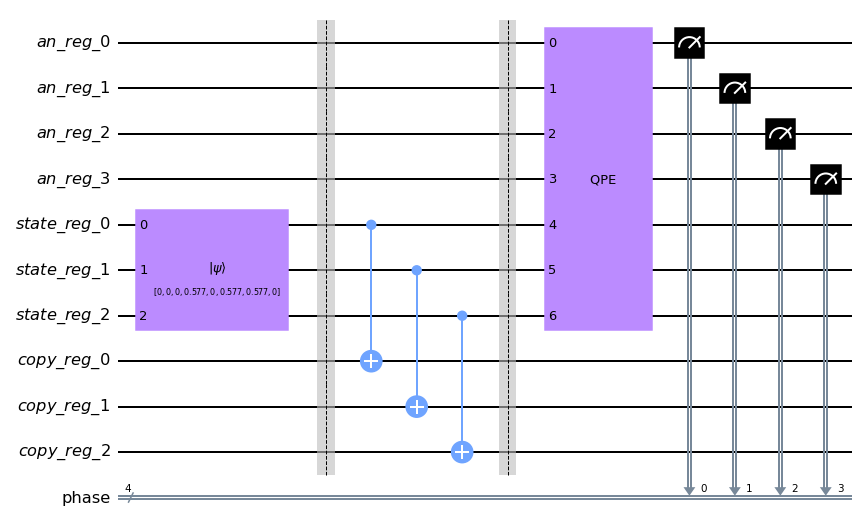

In [58]:
qc = qtda.initialize_projector(
    S1,
    circuit=qpe,
    initialization_qubits=list(range(num_qubits,num_qubits+n_vertices)),
    circuit_name='        QPE        '
    )
qc.add_register(ClassicalRegister(num_qubits, name="phase"))
for k in range(num_qubits):
    qc.measure(k,k)
qc.draw('mpl')

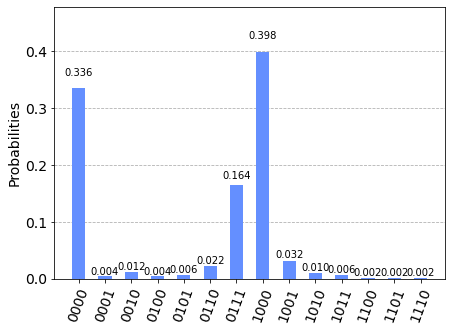

In [59]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=500)
data = job.result().get_counts(qc)
plot_histogram(data)

In [60]:
print('The number of 1-holes is: ', 3*data['0000']/500)

The number of 1-holes is:  1.008


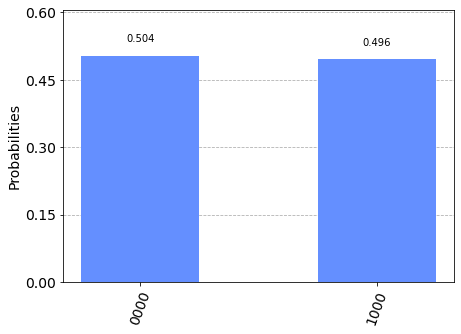

In [18]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=5000)
data = job.result().get_counts(qc)
plot_histogram(data)

In [95]:
def run_circuit(circuit):
    qasm_sim = Aer.get_backend('qasm_simulator')
    shots = 2048
    job = execute(circuit, qasm_sim, shots=1024)
    answer = job.result().get_counts(qc)
    return answer

{'0100': 517, '0011': 507}


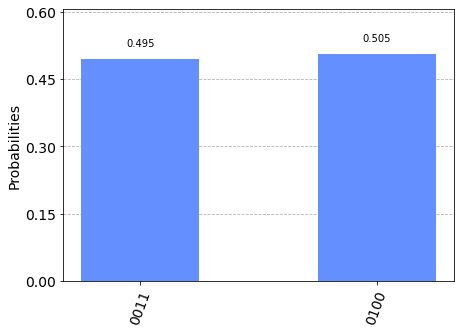

In [96]:
answer = run_circuit(qc)
print(answer)
plot_histogram(answer)